## S8 Assignment

* Batch Normalization is applied
* Batch Normalization is used on every layer other than prediction layer.
* No of parameters of model: 48512
* Test Accuracy: 77.8%
* Trained for 20 epochs and used less than 50k params

#### Analysis:

* Model is overfitting
* There was increase in learning rate and faster convergence with BN
* We have not only applied image normalization on the image but also applied batch normalization on every layer.


### Import heavenly gods / libraries

In [1]:
from __future__ import print_function
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.49139968, 0.48215827 ,0.44653124,), (0.24703233,0.24348505,0.26158768,))
                                       ])

## Load CIFAR10 dataset

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12887412.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Dataloader Arguments and Train/Test Dataloaders

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Data Statistics

* Compute mean , standard deviation, variance of training data
* Visualizing images in a batch

[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - Tensor Shape: torch.Size([50000, 32, 32, 3])
 - min: tensor(0.)
 - max: tensor(255.)
 - mean: tensor(120.7076)
 - std: tensor(64.1501)
 - var: tensor(4115.2324)
torch.Size([3, 32, 32])
torch.Size([128])


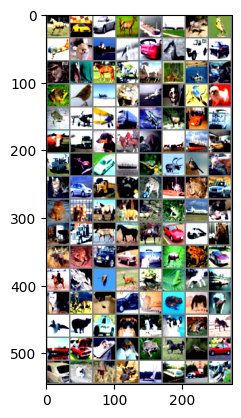

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.data
train_data_tensor = torch.Tensor(train_data)

print('[Train]')
print(' - Numpy Shape:', train.data.shape)
print(' - Tensor Shape:', train_data_tensor.size())
print(' - min:', torch.min(train_data_tensor))
print(' - max:', torch.max(train_data_tensor))
print(' - mean:', torch.mean(train_data_tensor))
print(' - std:', torch.std(train_data_tensor))
print(' - var:', torch.var(train_data_tensor))

def imshow(img, labels):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(labels)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images[0].shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

imshow(make_grid(images), "")


# Define model for batch normalization

C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11

In [7]:
class Model_4(nn.Module):
    def __init__(self):
        super(Model_4, self).__init__()
        dropout_value = 0.05
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 32, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 16

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 16
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=40, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(40),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 16
        # TRANSITION BLOCK 2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=40, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 16
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8
        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        ) # output_size = 8
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 1


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from model import Model_4

## model summary

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_nn = Model_4().to(device)
summary(model_nn, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]             512
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
          Dropout-12           [-1, 16, 32, 32]               0
        MaxPool2d-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1

### Functions to train and test the data

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_loss

* Specified LR Scheduler ( ReduceLROnPlateau ).
* Training data for 20 epochs
* Using SGD as optimizer


In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
model_nn =  Model_4().to(device)
optimizer = optim.SGD(model_nn.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, threshold=0.0001, threshold_mode='rel')
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_nn, device, train_loader, optimizer, epoch)
    test_loss = test(model_nn, device, test_loader)
    scheduler.step(test_loss)
    print("LR: ", scheduler.get_last_lr())

EPOCH: 0


Loss=1.418790578842163 Batch_id=390 Accuracy=40.56: 100%|██████████| 391/391 [00:24<00:00, 16.08it/s]



Test set: Average loss: 1.3508, Accuracy: 5021/10000 (50.21%)

LR:  [0.01]
EPOCH: 1


Loss=1.1894766092300415 Batch_id=390 Accuracy=59.13: 100%|██████████| 391/391 [00:24<00:00, 16.11it/s]



Test set: Average loss: 1.3583, Accuracy: 5031/10000 (50.31%)

LR:  [0.01]
EPOCH: 2


Loss=1.2701150178909302 Batch_id=390 Accuracy=64.89: 100%|██████████| 391/391 [00:21<00:00, 17.93it/s]



Test set: Average loss: 1.0555, Accuracy: 6148/10000 (61.48%)

LR:  [0.01]
EPOCH: 3


Loss=0.9952622652053833 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [00:16<00:00, 24.02it/s]



Test set: Average loss: 1.0564, Accuracy: 6219/10000 (62.19%)

LR:  [0.01]
EPOCH: 4


Loss=1.0003842115402222 Batch_id=390 Accuracy=71.01: 100%|██████████| 391/391 [00:16<00:00, 23.16it/s]



Test set: Average loss: 0.9156, Accuracy: 6720/10000 (67.20%)

LR:  [0.01]
EPOCH: 5


Loss=0.623053789138794 Batch_id=390 Accuracy=73.15: 100%|██████████| 391/391 [00:16<00:00, 23.62it/s]



Test set: Average loss: 0.8316, Accuracy: 7040/10000 (70.40%)

LR:  [0.01]
EPOCH: 6


Loss=0.6310200095176697 Batch_id=390 Accuracy=74.91: 100%|██████████| 391/391 [00:16<00:00, 23.70it/s]



Test set: Average loss: 0.7766, Accuracy: 7269/10000 (72.69%)

LR:  [0.01]
EPOCH: 7


Loss=0.7103736996650696 Batch_id=390 Accuracy=75.88: 100%|██████████| 391/391 [00:16<00:00, 24.00it/s]



Test set: Average loss: 0.7139, Accuracy: 7497/10000 (74.97%)

LR:  [0.01]
EPOCH: 8


Loss=0.4803451597690582 Batch_id=390 Accuracy=76.96: 100%|██████████| 391/391 [00:20<00:00, 19.46it/s]



Test set: Average loss: 0.7834, Accuracy: 7250/10000 (72.50%)

LR:  [0.01]
EPOCH: 9


Loss=0.7512746453285217 Batch_id=390 Accuracy=77.80: 100%|██████████| 391/391 [00:24<00:00, 16.26it/s]



Test set: Average loss: 0.7322, Accuracy: 7415/10000 (74.15%)

LR:  [0.01]
EPOCH: 10


Loss=0.46331173181533813 Batch_id=390 Accuracy=78.34: 100%|██████████| 391/391 [00:18<00:00, 21.50it/s]



Test set: Average loss: 0.7106, Accuracy: 7494/10000 (74.94%)

LR:  [0.01]
EPOCH: 11


Loss=0.6645415425300598 Batch_id=390 Accuracy=79.31: 100%|██████████| 391/391 [00:19<00:00, 20.00it/s]



Test set: Average loss: 0.7075, Accuracy: 7511/10000 (75.11%)

LR:  [0.01]
EPOCH: 12


Loss=0.5131785273551941 Batch_id=390 Accuracy=79.70: 100%|██████████| 391/391 [00:17<00:00, 22.00it/s]



Test set: Average loss: 0.6922, Accuracy: 7565/10000 (75.65%)

LR:  [0.01]
EPOCH: 13


Loss=0.5026586055755615 Batch_id=390 Accuracy=80.22: 100%|██████████| 391/391 [00:17<00:00, 22.94it/s]



Test set: Average loss: 0.6874, Accuracy: 7633/10000 (76.33%)

LR:  [0.01]
EPOCH: 14


Loss=0.4999980032444 Batch_id=390 Accuracy=80.92: 100%|██████████| 391/391 [00:17<00:00, 22.92it/s]



Test set: Average loss: 0.6777, Accuracy: 7623/10000 (76.23%)

LR:  [0.01]
EPOCH: 15


Loss=0.5685482621192932 Batch_id=390 Accuracy=81.06: 100%|██████████| 391/391 [00:17<00:00, 22.81it/s]



Test set: Average loss: 0.6839, Accuracy: 7658/10000 (76.58%)

LR:  [0.01]
EPOCH: 16


Loss=0.5435729622840881 Batch_id=390 Accuracy=81.14: 100%|██████████| 391/391 [00:18<00:00, 20.77it/s]



Test set: Average loss: 0.7024, Accuracy: 7553/10000 (75.53%)

LR:  [0.01]
EPOCH: 17


Loss=0.47290077805519104 Batch_id=390 Accuracy=81.82: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]



Test set: Average loss: 0.5976, Accuracy: 7940/10000 (79.40%)

LR:  [0.01]
EPOCH: 18


Loss=0.4267268776893616 Batch_id=390 Accuracy=81.89: 100%|██████████| 391/391 [00:17<00:00, 22.29it/s]



Test set: Average loss: 0.6537, Accuracy: 7722/10000 (77.22%)

LR:  [0.01]
EPOCH: 19


Loss=0.4711287021636963 Batch_id=390 Accuracy=82.48: 100%|██████████| 391/391 [00:16<00:00, 23.75it/s]



Test set: Average loss: 0.6371, Accuracy: 7782/10000 (77.82%)

LR:  [0.01]


### Plotted graph for training loss, testing loss, training and testing accuracy

Text(0.5, 1.0, 'Test Accuracy')

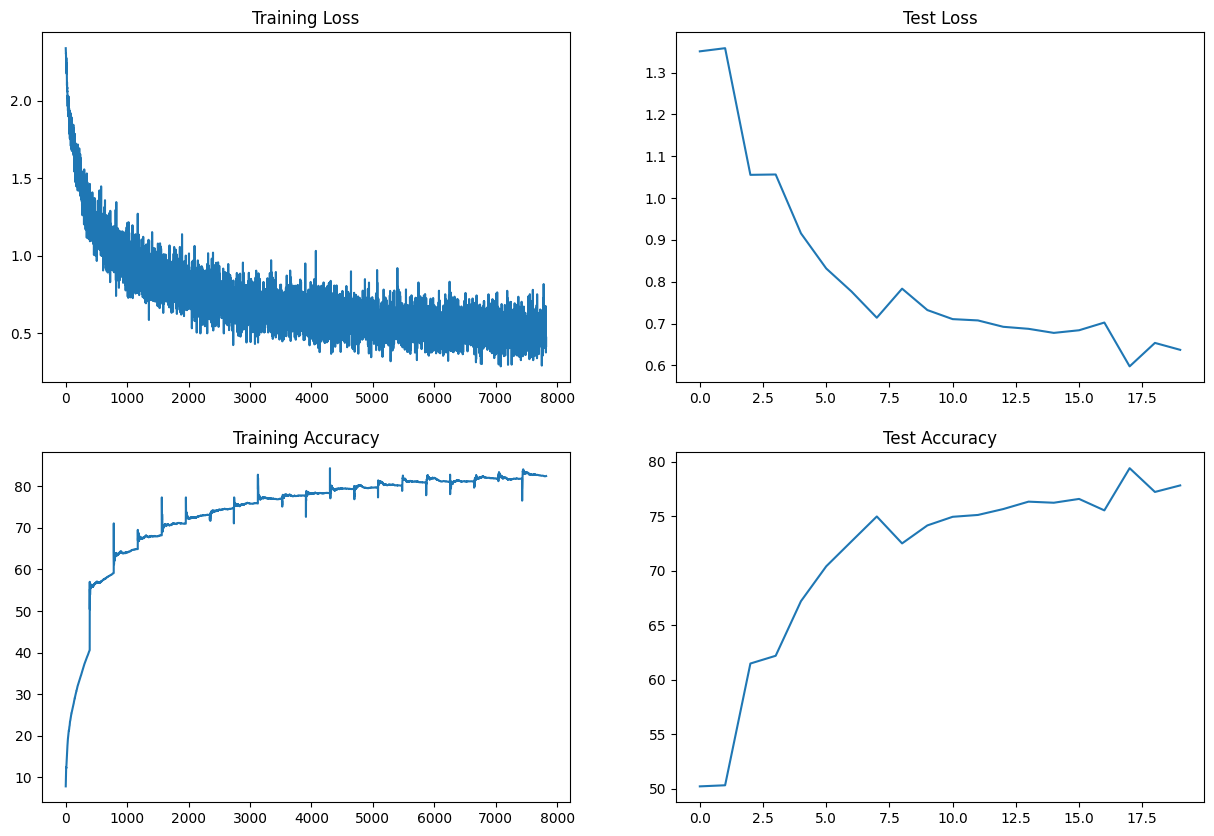

In [11]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Below code is written to find the misclassified images , labels and their correct labels.

In [12]:
# get mismatched images
model_nn.eval()
misclassified_images = []
misclassified_image_labels = []
correct_image_labels = []
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model_nn(data)
        pred = output.argmax(dim=1, keepdim=True)
        pred_classes = pred.squeeze().tolist()
        target_classes = target.view_as(pred).squeeze().tolist()
        for index in range(len(pred_classes)):
          if (pred_classes[index] != target_classes[index]):
            misclassified_images.append(data[index].cpu())
            misclassified_image_labels.append(class_labels[pred_classes[index]])
            correct_image_labels.append(class_labels[target_classes[index]])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Obtain first 10 misclassified images and their coreesponding ground truth ( actual values) and predicted values

In [13]:
first_ten_misclassified_images = misclassified_images[0:10]
first_ten_misclassified_labels = misclassified_image_labels[0:10]
first_ten_correct_labels = correct_image_labels[0:10]

In [14]:
grid_image = make_grid(first_ten_misclassified_images, nrow=5, normalize=True)

In [15]:
grid_image.shape

torch.Size([3, 70, 172])

In [18]:
misclassified_dict= {}
for index in range(0, len(first_ten_correct_labels)):
  misclassified_dict["GT." + str(index+1) + ": " + first_ten_correct_labels[index]] = "Pred: " + first_ten_misclassified_labels[index]

In [20]:
misclassified_dict

{'GT.1: dog': 'Pred: cat',
 'GT.2: bird': 'Pred: airplane',
 'GT.3: cat': 'Pred: dog',
 'GT.4: dog': 'Pred: cat',
 'GT.5: truck': 'Pred: cat',
 'GT.6: bird': 'Pred: cat',
 'GT.7: horse': 'Pred: airplane',
 'GT.8: horse': 'Pred: cat',
 'GT.9: bird': 'Pred: deer',
 'GT.10: automobile': 'Pred: truck'}

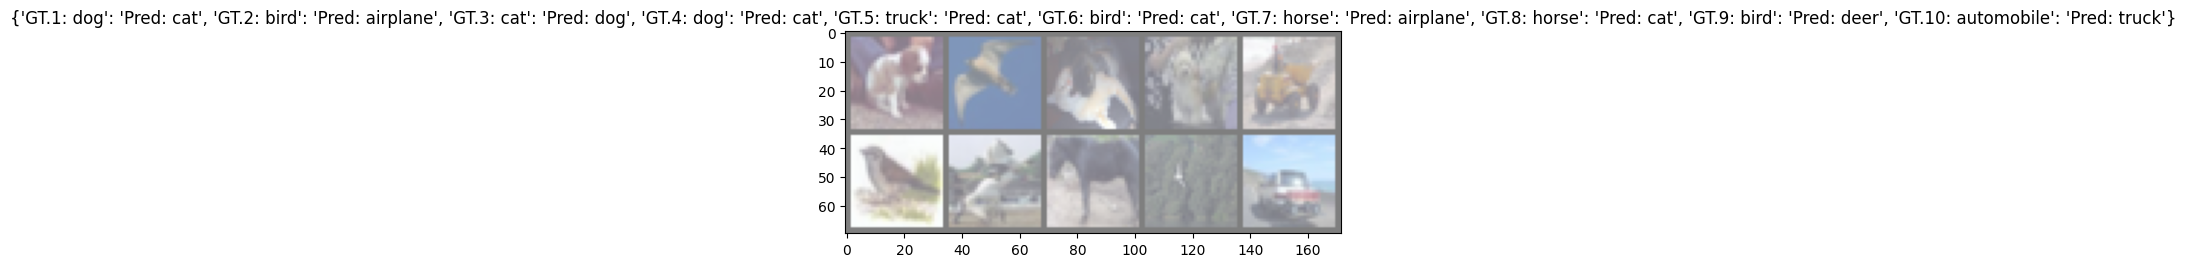

In [19]:
imshow(grid_image, misclassified_dict)